In [ ]:
%pip install praw

     |████████████████████████████████| 153kB 5.5MB/s 
     |████████████████████████████████| 204kB 7.5MB/s 


# Social Media Data Analysis With Reddit

Reddit is a forum-like social media platform where users post their submissions  (text, image, video, gifs, links etc.) under various subreddits. Our purpose is to analyze data collected from Reddit to get insights from the most popular 10 subreddits.

We are going to analyze the data in several steps:
* First, we will analyze the upvote ratios to determine the controversial posts in `r/popular`. 
* In the next step, we will analyze the comments of submissions with lowest upvotes ratios.
* Then, by counting how many times a subreddit appeared on `r/popular`, we will find the top 10 subreddits. 
* After that, we will analyze the submissions from each top 10 subreddits and compare their scores and number of comments.  
   
After the analysis, we have a section where we use Tensorflow to build a classification model. Using this model, we can classify submissions from aviation, cars, nvidia, sysadmin, nba and investing subreddits.

## Preparation

First we make import libraries, get our client id and secret.  
Here, we use unofficial Reddit API tool 'Python Reddit Access Wrapper (PRAW)'. 

In [ ]:
# username: cmpe2051angrybirds
# password: angrybirds

# username: angrybcmpe251
# password: angryb251

import numpy as np
import pandas as pd
import praw
import nltk
import matplotlib.pyplot as plt
from datetime import datetime

client_id = 'a1JhjlLlwNSz_Q'
secret = 'B7DQQYCVPTh-Wi_SExgdCWrpb6t7TQ'

client_id2 = 'dMMs-627PluVMw'
secret2 = 'h6gV1weZr88ysIfgz2Z9kTZUFon2fg'

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Next, we instantiate a Reddit class.  
Also, we set the period to `"month"` for top submissions.  

In [ ]:
redd = praw.Reddit(
    client_id=client_id,
    client_secret=secret,
    user_agent='AngryBirds_TermProject'
)

period = 'month'

## Data Collection

Now, we create an empty dataframe with columns:

1. Id
2. Title
3. Author
4. Score
5. Upvote Ratio (= Upvotes/Total Votes)
6. Number of Comments
7. Subreddit
8. Permalink
9. Created (UTC)

Next, we collect top 1000 submissions of the last month in the subreddit `r/popular` (*).  
Then, we populate the dataframe with the metadata of these posts.  

**Caution:** Since, we are fetching up to 1000 submissions, it may take some time.  

(*)Brief information about `r/popular`: Although there are countless subreddits on Reddit, there are some special subreddits moderated by the Reddit administrators. `r/popular` and `r/all` are two of them. `r/all` contains submissions with high score from all over Reddit. `r/popular` is almost same as `r/all` except it is filtered down so that it does not contain fake information, explicit etc. content. That is, `r/popular` is a nicer looking version of `r/all`. That's why we are fetching submissions appearing on `r/popular`.

In [ ]:
df = pd.read_pickle('reddit_data.pkl')
#df = pd.DataFrame({'id':[],'title':[], 'author':[], 'score':[], 'upvote_ratio':[], 'num_comments':[], 'subreddit':[], 'permalink':[], 'created_utc':[]})
popular = redd.subreddit('popular')
#counter = 0
#i = 0

#for submission in popular.top(period,limit=1000):
#    if i >= 100:
#        print('Fetched {} records'.format(counter))
#        i = 0

#    df = df.append({
#        'id': submission.id,
#        'title': submission.title,
#        'author': submission.author,
#        'score': submission.score,
#        'upvote_ratio': submission.upvote_ratio,
#        'num_comments': submission.num_comments,
#        'subreddit': submission.subreddit.display_name,
#        'permalink': submission.permalink,
#      'created_utc': str(datetime.fromtimestamp(int(float(submission.created_utc))))
#    }, ignore_index=True)
#    counter = counter + 1
#    i = i + 1
    
#df.to_pickle('reddit_data.pkl', protocol=3)
df.head()

,id,title,author,score,upvote_ratio,num_comments,subreddit,permalink,created_utc
0,jr5wtk,"""Are you sure you want to go back to the Old V...",lapapinton,194660.0,0.88,4994.0,funny,/r/funny/comments/jr5wtk/are_you_sure_you_want...,2020-11-09 20:43:45
1,k4qide,An anti-gay Hungarian politician has resigned ...,stem12345679,194818.0,0.90,8324.0,worldnews,/r/worldnews/comments/k4qide/an_antigay_hungar...,2020-12-01 18:15:32
2,juqm4s,There are massive floods in southeast Mexico r...,m3antar,189868.0,0.93,1805.0,nextfuckinglevel,/r/nextfuckinglevel/comments/juqm4s/there_are_...,2020-11-15 18:25:46
3,jv4nra,Every time,ZyleErelis,170140.0,0.95,2277.0,memes,/r/memes/comments/jv4nra/every_time/,2020-11-16 10:33:42
4,jvawxo,Been gaming with this dude for 15 years. Since...,ghost_knight1121,166596.0,0.86,3582.0,gaming,/r/gaming/comments/jvawxo/been_gaming_with_thi...,2020-11-16 17:29:50


## Analyzing the upvote ratios to determine controversial submissions.

Let's begin to analyze the data.
Before we find the top 10 subreddit, we will look at the upvote ratios to determine whether there is any controversial submission. Because if a submission has low upvote ratio, it means that the content is not very popular.

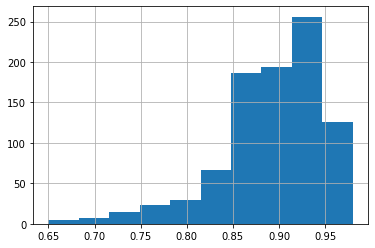

In [ ]:
df.upvote_ratio.hist()

It looks like majority of the submissions have upvote ratio larger than 0.84.  
So, we seperate the submission accordingly.  

In [ ]:
low_ratio = df[df.upvote_ratio < .84]
high_ratio = df[df.upvote_ratio >= .84]

total = df.shape[0]
low_count = low_ratio.shape[0]
high_count = high_ratio.shape[0]

low_percent = low_count / total * 100
high_percent = high_count / total * 100

print('Percentage of the submissions with upvote ratio lower than %84: ' + str(low_percent))
print('Percentage of the submissions with upvote ratio higher than %84: ' + str(high_percent))
print('')
print('Subreddit of the submissions with low upvote ratio:')
print(low_ratio.subreddit.value_counts())

Percentage of the submissions with upvote ratio lower than %84: 13.766519823788546
Percentage of the submissions with upvote ratio higher than %84: 86.23348017621146

Subreddit of the submissions with low upvote ratio:
pics                    33
WhitePeopleTwitter      12
news                     9
gaming                   9
worldnews                6
PoliticalHumor           5
politics                 5
funny                    5
aww                      4
facepalm                 4
AskReddit                3
MurderedByWords          3
nextfuckinglevel         3
BlackPeopleTwitter       2
Showerthoughts           2
gifs                     2
PublicFreakout           2
insanepeoplefacebook     2
memes                    2
MadeMeSmile              1
LifeProTips              1
science                  1
MurderedByAOC            1
awfuleverything          1
Unexpected               1
wholesomememes           1
dankmemes                1
WatchPeopleDieInside     1
mildlyinfuriating        

## Analyzing the most controversial 10 submissions

Now, we will sort the rows of `df` by `upvote_ratios` in ascending order and pick the top 10 submissions.

In [ ]:
controversial = df.sort_values(by='upvote_ratio',ascending=True)[:10]
controversial

,id,title,author,score,upvote_ratio,num_comments,subreddit,permalink,created_utc
340,ju82uy,Two Navajo women exercising their 1st amendmen...,DontSearchMyBasement,99453.0,0.65,4327.0,pics,/r/pics/comments/ju82uy/two_navajo_women_exerc...,2020-11-14 19:53:23
816,k49zt4,Update from previous post. After giving up gam...,Hannibal_Hector,79600.0,0.66,2196.0,gaming,/r/gaming/comments/k49zt4/update_from_previous...,2020-12-01 01:03:33
177,k5cand,Hopefully this will put an end to Trump's elec...,Spicylemon,113823.0,0.66,3889.0,pics,/r/pics/comments/k5cand/hopefully_this_will_pu...,2020-12-02 16:19:23
494,jrxt5o,Tim Allen just posted this and said this alway...,holyfruits,90137.0,0.68,3261.0,pics,/r/pics/comments/jrxt5o/tim_allen_just_posted_...,2020-11-11 00:51:54
350,jt0f43,Joe Biden with a beard needs to be a thing,idea4granted,98970.0,0.68,5193.0,pics,/r/pics/comments/jt0f43/joe_biden_with_a_beard...,2020-11-12 18:46:04
464,k1ncfz,"40th birthday, my wife is sick, my newest cons...",scraffe,91937.0,0.70,2736.0,gaming,/r/gaming/comments/k1ncfz/40th_birthday_my_wif...,2020-11-26 21:03:10
337,jvfkmc,Joe Biden’s 1967 Corvette which was gifted to ...,TetraCGT,99515.0,0.70,5330.0,pics,/r/pics/comments/jvfkmc/joe_bidens_1967_corvet...,2020-11-16 21:26:40
382,jxelim,A photo of the presidents and their dog.,D0NW0N,96342.0,0.70,2010.0,pics,/r/pics/comments/jxelim/a_photo_of_the_preside...,2020-11-20 00:12:08
769,jtixgo,In front of the White House now,ohnoh18,80720.0,0.70,5818.0,pics,/r/pics/comments/jtixgo/in_front_of_the_white_...,2020-11-13 16:33:31
756,js5lwk,Time Is Running Out,dittidot,81149.0,0.70,1956.0,pics,/r/pics/comments/js5lwk/time_is_running_out/,2020-11-11 10:10:25


Next, we put all the title in `controversial` into `text`.

In [ ]:
text = ' '.join(controversial.title.tolist())

Next, we put all the comments in each submission in `controversial` into `text`.

**Caution**: We are fetching a lot of data. It may take some time.

In [ ]:
for _id in controversial.id.tolist():
  submission = redd.submission(_id)
  submission.comment_sort = 'best' # or we can use 'controversial' to get the comments with the most downvotes.
  submission.comment_limit = 100
  submission.comments.replace_more(limit=0) # this is a trick so that `comments.list()` below returns list of objects of the `comment` class, not the `MoreComments` class
  text = text + ' '.join([comm.body for comm in submission.comments.list()])
  print('Fetched comments for {}'.format(_id))

Fetched comments for ju82uy
Fetched comments for k49zt4
Fetched comments for k5cand
Fetched comments for jrxt5o
Fetched comments for jt0f43
Fetched comments for k1ncfz
Fetched comments for jvfkmc
Fetched comments for jxelim
Fetched comments for jtixgo
Fetched comments for js5lwk


Next, we filter `text` and calculate frequency distribution. Then, pick the most frequent 20 words.


In [ ]:
from nltk.corpus import stopwords

my_stopwords = [
                'like', 'would', 'one', 'people', 'get', 'time', 'even', 'got',
                'never', 'know', 'really', 'think', 'first', 'good', 'also', 
                'still', 'its', 'fucking', 'shit', 'love', 'right', 'way'
]

def clean(word):
  if word[-1] == '.': # its. -> its
    word = word[:-1]

  if word[-2:] == "'s":
    word = word[:-2]

  if word[-2:] == '’s':
    word = word[:-2]

  return word

def filter(word):
  if word in my_stopwords:
    return False

  if word in stopwords.words('english'):
    return False

  if word.startswith('http://'):
    return False

  if word.startswith('https://'):
    return False

  return True

words = text.lower().split()
words = [clean(word) for word in words]
clean = [word for word in words if filter(word)]
freq = nltk.FreqDist(clean)

In [ ]:
freq.pprint(maxlen=20)

FreqDist({'trump': 93, 'biden': 40, 'years': 34, 'president': 34, "i'm": 32, 'white': 31, 'much': 31, 'say': 31, 'see': 30, 'could': 30, 'going': 30, 'look': 29, 'ever': 29, 'said': 28, 'something': 28, 'back': 27, 'post': 26, 'someone': 26, 'man': 26, 'around': 25, ...})


## Findind the top 10 subreddits

Next, we count how many times subreddits have appeared on the top 1000 submissions from the last month and pick the top ten subreddits.

In [ ]:
best_subreddits = df.subreddit.value_counts()
best_subreddits[:10]

memes                 128
dankmemes              81
nextfuckinglevel       74
aww                    63
pics                   63
interestingasfuck      48
WhitePeopleTwitter     40
funny                  40
gaming                 36
MadeMeSmile            30
Name: subreddit, dtype: int64

Now, in order to analyze the top 10 individual subreddits, we create a dictionary where each key is the name of the subreddit and the corresponding value is a dataframe populated by the metadata of the top 50 submissions of the last month.

**Caution**: We are fetching a lot of data. It may take some time.

In [ ]:
top_ten_subs = best_subreddits.index.values.tolist()[:10]
sub_data = dict()
for sub in top_ten_subs:
    sub_data[sub] = pd.read_pickle('{}.pkl'.format(sub))
    
    #sub_data[sub] = pd.DataFrame({'id':[],'title':[], 'author':[], 'score':[], 'upvote_ratio':[], 'num_comments':[], 'permalink':[], 'created_utc':[]})
    
    #for submission in redd.subreddit(sub).top(period, limit=50):
    #    sub_data[sub] = sub_data[sub].append({
    #        'id': submission.id,
    #        'title': submission.title,
    #        'author': submission.author,
    #        'score': submission.score,
    #        'upvote_ratio': submission.upvote_ratio,
    #        'num_comments': submission.num_comments,
    #        'permalink': submission.permalink,
    #        'created_utc': str(datetime.fromtimestamp(int(float(submission.created_utc))))
    #    }, ignore_index=True)
        
    print('Finished collecting data for {}'.format(sub))
        
    #sub_data[sub].to_pickle('{}.pkl'.format(sub),protocol=3)

Finished collecting data for memes
Finished collecting data for dankmemes
Finished collecting data for nextfuckinglevel
Finished collecting data for aww
Finished collecting data for pics
Finished collecting data for interestingasfuck
Finished collecting data for WhitePeopleTwitter
Finished collecting data for funny
Finished collecting data for gaming
Finished collecting data for MadeMeSmile


In [ ]:
# Example
#sub_data['memes'].head()

### Statistical analysis of the score in the top 10 subreddits

We want to compare the popularity between the top 10 subreddits. We do this by analyzing the score of the submissions.



We look up the maximum, minimum, mean, median and standard deviation of the scores of the submissions in the previos dataframes.

In [ ]:
max_scores = [sub_data[sub].score.max() for sub in top_ten_subs]
mean_scores = [sub_data[sub].score.mean() for sub in top_ten_subs]
median_scores = [sub_data[sub].score.median() for sub in top_ten_subs]
min_scores = [sub_data[sub].score.min() for sub in top_ten_subs]
std_scores = [sub_data[sub].score.std() for sub in top_ten_subs]

top_ten_scores = pd.DataFrame({
    'Min': min_scores,
    'Max': max_scores,
    'Median': median_scores,
    'Mean': mean_scores,
    'Std Deviation': std_scores,
    'Std Dev / Mean': np.array(std_scores) / np.array(mean_scores)
}, index=top_ten_subs)

top_ten_scores

,Min,Max,Median,Mean,Std Deviation,Std Dev / Mean
memes,123561.0,170852.0,141678.5,141767.60,12762.045949,0.090021
dankmemes,88633.0,138340.0,102099.5,105342.72,12222.523581,0.116026
nextfuckinglevel,94473.0,189872.0,111969.5,115426.78,16611.981813,0.143918
aww,84327.0,154057.0,99651.0,104323.96,16458.868731,0.157767
pics,85435.0,164805.0,102105.5,107046.84,17940.884047,0.167598
interestingasfuck,78496.0,143871.0,97965.5,101151.50,16912.186659,0.167197
WhitePeopleTwitter,73233.0,136364.0,88677.5,91853.24,13670.187780,0.148826
funny,70895.0,194659.0,91503.5,98700.72,25090.862376,0.254212
gaming,71498.0,166600.0,86664.0,94365.70,22663.230780,0.240164
MadeMeSmile,68348.0,150853.0,81422.5,87177.46,17757.527863,0.203694


Here, we plot the scores of the individual submissions.

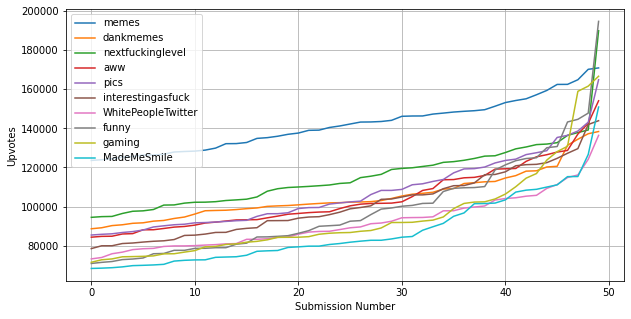

In [ ]:
plt.figure(figsize=(10,5))
for sub in top_ten_subs:
    plt.plot(sub_data[sub].score.sort_values(ascending=True,ignore_index=True), label=sub)

plt.xlabel('Submission Number')   
plt.ylabel('Upvotes')
plt.grid()
plt.legend()
plt.show()

### Statistical analysis of the number of comments in the top 10 subreddits.

Now, we want to find where the most discussion happens. We do this by comparing the number of comments.

In [ ]:
max_num_comments = [sub_data[sub].num_comments.max() for sub in top_ten_subs]
mean_num_comments = [sub_data[sub].num_comments.mean() for sub in top_ten_subs]
median_num_comments = [sub_data[sub].num_comments.median() for sub in top_ten_subs]
min_num_comments = [sub_data[sub].num_comments.min() for sub in top_ten_subs]
std_num_comments = [sub_data[sub].num_comments.std() for sub in top_ten_subs]

top_ten_num_comments = pd.DataFrame({
    'Min': min_num_comments,
    'Max': max_num_comments,
    'Median': median_num_comments,
    'Mean': mean_num_comments,
    'Standard Deviation': std_num_comments,
    'Std Dev / Mean': np.array(std_num_comments) / np.array(mean_num_comments) 
}, index=top_ten_subs)

top_ten_num_comments

,Min,Max,Median,Mean,Standard Deviation,Std Dev / Mean
memes,397.0,2567.0,876.0,1039.96,539.942437,0.519195
dankmemes,276.0,2258.0,628.0,783.74,451.211286,0.575716
nextfuckinglevel,335.0,4858.0,1419.0,1677.82,974.494609,0.580810
aww,324.0,2829.0,985.0,1148.86,600.868793,0.523013
pics,844.0,10707.0,2279.0,2971.08,1997.652396,0.672366
interestingasfuck,221.0,3531.0,1367.0,1539.40,744.080037,0.483357
WhitePeopleTwitter,264.0,6580.0,1650.0,1724.58,1070.025960,0.620456
funny,268.0,7803.0,1162.5,1476.30,1288.194770,0.872583
gaming,347.0,5855.0,1449.0,1726.62,1154.797922,0.668820
MadeMeSmile,166.0,2580.0,838.5,906.16,509.218744,0.561952


Here, plotting the number of comment for each individual submission.

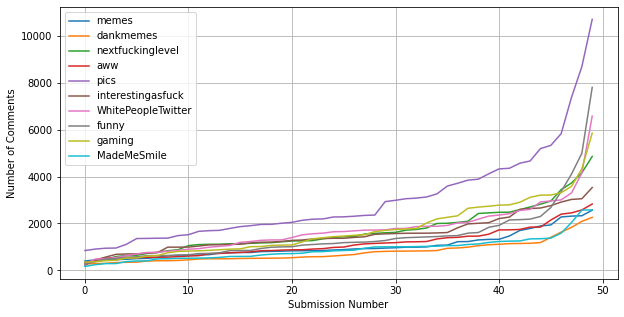

In [ ]:
plt.figure(figsize=(10,5))
for sub in top_ten_subs:
    plt.plot(sub_data[sub].num_comments.sort_values(ascending=True,ignore_index=True), label=sub)

plt.xlabel('Submission Number')   
plt.ylabel('Number of Comments')
plt.grid()
plt.legend()
plt.show()

## Classifying submisisons

In this section, we will use Tensorflow to build several classification models from artificial neural networkds. First, we collect submission titles from:

* cars
* aviation
* sysadmin
* nba
* investing
* nvidia

subreddits. Then, we will partition this data into three parts: training/fitting, validation, testing. To convert our text data into numerical vectors, we will use [a tf.keras layer](https://tfhub.dev/google/nnlm-en-dim50/2) from Tensorflow Hub built by google. This layer converts each string into 50-length numerical vectors.


### Preparation for our models

Here, we include `tensorflow` and `tensorflow_hub` for our models and `os` for file operations.

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

import os

We define a function to collect data. First, it checks whether the pickle exists. If it exists, it reads from the file into a `pd.Series` and returns it. If it does not exists, it collects the data from Reddit via `redd` created before and saves the data into a pickle file

In [ ]:
def collectdata(subname):
  print(f'Collecting data for {subname}')
  fname = f'{subname}.pkl'
  if fname in os.listdir():
    ret = pd.read_pickle(fname)
    return ret

  ret = pd.Series([submission.title for submission in redd.subreddit(sub).top('month', limit=1000)])
  ret.to_pickle(fname, protocol=3)
  return ret

### Collecting data for models

After the preperations, we start collecting the data. We fetch the titles of top 1000 submissions in the last month from the subreddits below and put them into a single dataframe `titles` with columns `title` and `subreddit`.

In [ ]:
subs = ['cars','aviation','sysadmin','nba','investing', 'nvidia']
titles = pd.DataFrame({
    'title':[],
    'subreddit':[]
})
for sub in subs:
  titles = pd.concat([
                      titles,
                      pd.DataFrame({
                          'title': collectdata(sub),
                          'subreddit': sub
                      })
  ], ignore_index=True)

In [ ]:
for sub in subs:
  print(f'{sub}:', titles[titles.subreddit == sub].shape)

total = titles.shape[0]
print(f'total: {total}')

cars: (995, 2)
aviation: (997, 2)
sysadmin: (998, 2)
nba: (1000, 2)
investing: (992, 2)
nvidia: (997, 2)
total: 5979


Now, we will convert pandas.DataFrame objects to tf.data. First, we shuffle the subreddit. Then, we convert the data in the `subreddit` column to numerical values. Then, we seperate `title` into three parts: training set, validation set and test set. Finally, we convert each of them to `tf.data.Dataset` objects.

In [ ]:
titles = titles.sample(frac=1.)
titles.subreddit = pd.Categorical(titles.subreddit)
titles.subreddit = titles.subreddit.cat.codes

train = titles[:int(0.6*total)]
valid = titles[int(0.6*total):int(0.9*total)]
test = titles[int(0.9*total):]

train = tf.data.Dataset.from_tensor_slices((train.title, train.subreddit))
valid = tf.data.Dataset.from_tensor_slices((valid.title, valid.subreddit))
test = tf.data.Dataset.from_tensor_slices((test.title, test.subreddit))

In [ ]:
list(train.as_numpy_iterator())[:10]

[(b'Is there any reason NOT to implement caching for files in an enterprise with multiple far distant branches?',
  5),
 (b'RTX 3080 Comparison / Buy Aid - by popular request here is the TechPowerUp.con reviews all together, I also added 1080P this time, hope this helps everyone with their decisions!',
  4),
 (b"Al Horford's sister, Anna Horford, shares a frightening and toxic message she received from a 76ers fan (warning: extremely vulgar)",
  3),
 (b'Aventador S x IPE Exhaust', 1),
 (b'Does anyone have experience about Degiro???', 2),
 (b'Pacemaker move master resource only once', 5),
 (b'MANLI submits GeForce RTX 3080 Ti, RTX 3070 Ti, RTX 3060 and RTX 3050 to EEC',
  4),
 (b'Smith Mountain Lake Virginia #cessna #c172', 0),
 (b'Mitsubishi Mirage Owners Reach 414,000 Miles In Their Little Mitsu', 1),
 (b'Russell Westbrook trade rumors: Knicks interested in making Rockets star centerpiece of their team, per report',
  3)]

### Building our model(s)

Now, we will begin constructing our model. Our model will consist of layers, which takes input, processes it and gives output.

Our first layer turns a string to vector of floating point numbers. This layers is built by Google and can be downloaded to use in models.

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)

A demonstration of our embedding layer. Note that, as told in the layer's Tensorflow Hub page, this layer takes batches of records, not individual records.

In [ ]:
hub_layer(titles.title[:1])

<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[-0.06013731,  0.09383889,  0.1102796 ,  0.15052272, -0.35095313,
         0.01922084, -0.02180864,  0.25244597, -0.07656427,  0.13671517,
        -0.08069712,  0.26735878, -0.11985904, -0.22354114,  0.08248442,
        -0.0911561 ,  0.01538005, -0.03304596,  0.10608803, -0.10598847,
         0.10055049, -0.10670935,  0.39878225, -0.21385325, -0.15614708,
        -0.10879327, -0.19923417,  0.09184504,  0.13751385, -0.19370176,
        -0.10735704, -0.14814022,  0.12163997, -0.25417593, -0.23514955,
        -0.18104656,  0.14948268, -0.06614697,  0.12111704,  0.02099738,
         0.23478185,  0.06016421, -0.16350874,  0.08639163, -0.09570008,
        -0.24261329, -0.03636512, -0.00153842,  0.35213387,  0.27696213]],
      dtype=float32)>

Here, we define our first layer. It consists of an embedding layer, two hidden densely connected neural network (nn) layers and one output layer of the size of category list.

In [ ]:
model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(len(subs))
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Next, we train our model. Observe that we are experiencing overfitting as our training accuracy outgrows the validation accuracy. (This is one of the symptoms of overfitting.)

In [ ]:
model.fit(train.batch(100), epochs=5, validation_data=valid.batch(50), verbose=1)

Epoch 1/5
36/36 [==============================] - 16s 454ms/step - loss: 1.7160 - accuracy: 0.3476 - val_loss: 1.6477 - val_accuracy: 0.4047
Epoch 2/5
36/36 [==============================] - 16s 452ms/step - loss: 1.4918 - accuracy: 0.5174 - val_loss: 1.4189 - val_accuracy: 0.5139
Epoch 3/5
36/36 [==============================] - 16s 450ms/step - loss: 1.1636 - accuracy: 0.6850 - val_loss: 1.1378 - val_accuracy: 0.6433
Epoch 4/5
36/36 [==============================] - 16s 454ms/step - loss: 0.8131 - accuracy: 0.8132 - val_loss: 0.9110 - val_accuracy: 0.7179
Epoch 5/5
36/36 [==============================] - 16s 454ms/step - loss: 0.5198 - accuracy: 0.9021 - val_loss: 0.7616 - val_accuracy: 0.7603


We see that our model actually overfit the data because our test accuracy is not high as out training accuracy.

In [ ]:
results = model.evaluate(test.batch(10), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

60/60 - 0s - loss: 0.7486 - accuracy: 0.7358
loss: 0.749
accuracy: 0.736


After experiencing the overfit, we try to solve the issue. Following the recommendations in [here](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit), we first add a regularizer to our dense nn layers in order to punish very wild coefficients. Next, we add a dropout layer to deactivate some of the neurons. However, after all of this, we are still stuck the accuracy of about %80.

In [ ]:
l2model = tf.keras.Sequential([
                               hub_layer,
                               tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.001)),
                               tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.001)),
                               tf.keras.layers.Dense(len(subs))
])

l2model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
l2model.fit(train.batch(50), epochs=5, validation_data=valid.batch(10), verbose=1)

Epoch 1/5
72/72 [==============================] - 33s 465ms/step - loss: 1.7353 - accuracy: 0.3432 - val_loss: 1.6045 - val_accuracy: 0.4788
Epoch 2/5
72/72 [==============================] - 33s 463ms/step - loss: 1.2036 - accuracy: 0.7190 - val_loss: 1.0951 - val_accuracy: 0.6984
Epoch 3/5
72/72 [==============================] - 33s 459ms/step - loss: 0.5934 - accuracy: 0.9208 - val_loss: 0.7703 - val_accuracy: 0.7860
Epoch 4/5
72/72 [==============================] - 33s 460ms/step - loss: 0.2706 - accuracy: 0.9727 - val_loss: 0.6686 - val_accuracy: 0.8055
Epoch 5/5
72/72 [==============================] - 35s 492ms/step - loss: 0.1601 - accuracy: 0.9919 - val_loss: 0.6483 - val_accuracy: 0.8082


In [ ]:
l2results = l2model.evaluate(test.batch(10), verbose=2)

for name, value in zip(l2model.metrics_names, l2results):
  print("%s: %.3f" % (name, value))

60/60 - 0s - loss: 0.6251 - accuracy: 0.8110
loss: 0.625
accuracy: 0.811


In [ ]:
dropmodel = tf.keras.Sequential([
                                   hub_layer,
                                   tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.001)),
                                   tf.keras.layers.Dropout(0.2),
                                   tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.001)),
                                   tf.keras.layers.Dropout(0.2),
                                   tf.keras.layers.Dense(len(subs))
])
dropmodel.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
dropmodel.fit(train.batch(100), epochs=5, validation_data=valid.batch(40), verbose=1)

Epoch 1/5
36/36 [==============================] - 17s 461ms/step - loss: 1.7009 - accuracy: 0.3228 - val_loss: 1.6096 - val_accuracy: 0.4476
Epoch 2/5
36/36 [==============================] - 16s 452ms/step - loss: 1.4092 - accuracy: 0.5498 - val_loss: 1.3487 - val_accuracy: 0.6204
Epoch 3/5
36/36 [==============================] - 16s 448ms/step - loss: 1.1001 - accuracy: 0.7145 - val_loss: 1.0985 - val_accuracy: 0.7274
Epoch 4/5
36/36 [==============================] - 16s 454ms/step - loss: 0.7985 - accuracy: 0.8177 - val_loss: 0.8875 - val_accuracy: 0.7776
Epoch 5/5
36/36 [==============================] - 16s 449ms/step - loss: 0.5864 - accuracy: 0.8673 - val_loss: 0.7597 - val_accuracy: 0.7954


In [ ]:
dropresults = dropmodel.evaluate(test.batch(10), verbose=2)

for name, value in zip(dropmodel.metrics_names, dropresults):
  print("%s: %.3f" % (name, value))

60/60 - 0s - loss: 0.7300 - accuracy: 0.8027
loss: 0.730
accuracy: 0.803


### Live demonstration

Now, we perform a live demonstration.(Actually doing the same thing as model testing.). We pick a very recent submission title and feed it into our model. Then, we turn the results into probobabilities. We pick the category with the highest probability and the filter `titles` dataframe with the same category.

In [ ]:
sf = tf.keras.layers.Softmax()
pred = dropmodel(tf.constant(['']))
pred

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[ 0.15664792, -0.49244422, -1.8233726 , -3.2083042 ,  0.15838209,
         2.3361938 ]], dtype=float32)>

In [ ]:
sub = np.argmax(sf(pred))
titles[titles.subreddit == sub]

,title,subreddit
2953,Is there any reason NOT to implement caching f...,5
2579,Pacemaker move master resource only once,5
2257,Locking Down Executives,5
2251,Replicate Keepass on O365 / Azure - password v...,5
2719,Users Android Phone Facebook App Hack Concern?,5
...,...,...
2596,Language IME software?,5
2242,"Am I Getting Fucked Friday, November 27th, 202...",5
2836,WUfB...give me something better.,5
2329,Best way to automate builds,5
